In [2]:
import numpy as np
import pandas as pd
import glob
import pyvtk
from sklearn.decomposition import PCA
import vtk
import matplotlib.pyplot as plt
from scipy import interpolate
import datetime
import seaborn as sns

def GetVtk(filepath):
    reader = vtk.vtkPolyDataReader()
    reader.ReadAllVectorsOn()
    reader.ReadAllScalarsOn()
    reader.SetFileName(filepath)
    reader.Update()
    polydata = reader.GetOutput()

    ######################################################
    #             複数のCellがあるときに使う              #
    #                                                    #
    # for i in range(polydata.GetNumberOfCells()):       #
    #    pts = polydata.GetCell(i).GetPoints()           # 
    #    np_pts = np.array([pts.GetPoint(i) for i in     # 
    #             range(pts.GetNumberOfPoints())])       #
    #                                                    #
    ######################################################

    pts = polydata.GetPoints()    
    np_pts = np.array([pts.GetPoint(i) for i in range(pts.GetNumberOfPoints())])
    np_pts = np_pts - np_pts[0] # distalの始点を(0, 0, 0)まで移動

    Curv = np.array(polydata.GetPointData().GetArray("Curvature"))
    Tors = np.array(polydata.GetPointData().GetArray("Torsion"))
    Radius = np.array(polydata.GetPointData().GetArray("MaximumInscribedSphereRadius"))
    Abscissas = np.array(polydata.GetPointData().GetArray("Abscissas"))
    ParallelTransportNormals = np.array(polydata.GetPointData().GetArray("ParallelTransportNormals"))

    return np_pts, Curv, Tors, Radius, Abscissas, ParallelTransportNormals

In [3]:
ROOT = ".\\scaling\\resamp_attr_ascii\\"
files = glob.glob(ROOT + "*.vtk")
print (len(files),"files in total.")

for i in range(len(files)):
    # print ("!!!!!!!", i)
    pts, Curv, Tors, Radius, Abscissas, PTN = GetVtk(files[i])

104 files in total.


In [4]:
LEN = 64

mean_curv = np.zeros(LEN)
mean_tors =  np.zeros(LEN)
mean_rad =  np.zeros(LEN)

curvs = []
torss = []
absci = []
rad = []

for i in range(len(files)):
    # print ("!!!!!!!", i)
    pts, Curv, Tors, Radius, Abscissas, PTN = GetVtk(files[i])
    mean_curv = mean_curv + Curv
    mean_tors = mean_tors + Tors
    mean_rad = mean_rad + Radius
    curvs.append(Curv)
    torss.append(Tors)
    absci.append(Abscissas)
    rad.append(Radius)

mean_curv = mean_curv/(len(files))
mean_tors = mean_tors/(len(files))

absci = np.array(absci)
curvs = np.array(curvs)
torss = np.array(torss)
rad = np.array(rad)


for i in range(len(files)):  
    fig = plt.figure(dpi=300,figsize=(10,3))
    ax = fig.add_subplot(111)
    lns1 = ax.plot(absci[i], curvs[i], label="curvature", color="red")
    lns11 = ax.plot(absci[i],mean_curv, label="mean curv", linestyle=":", color="red", alpha=0.5) 
    ax.fill_between(absci[i], 0, mean_curv, color="red",alpha=0.2)
    ax2 = plt.twinx(ax)
    lns2 = ax2.plot(absci[i], torss[i], label="torsion",color="dimgray")
    lns22 = ax2.plot(absci[i], mean_tors, label="mean tors", color="dimgray", alpha=0.5,linestyle=":")
    ax2.fill_between(absci[i], -2, mean_tors, color="dimgray",alpha=0.2)
    lns = lns1 + lns11 + lns2 + lns22
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=0)
    
    ax.set_ylim((0,1))
    ax2.set_ylim((-1,1))
    plt.savefig(".\\curv_tors\\{}.png".format(files[i].split("\\")[-1]))
    plt.close()

# Auto-corelation of Radius / Curvature.

(104, 104)


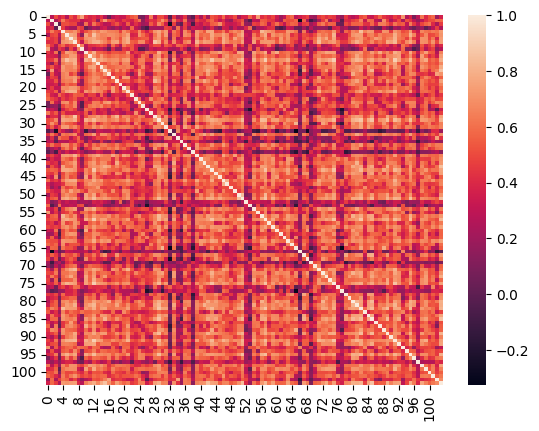

In [5]:
r_corr = np.corrcoef(rad)

print (r_corr.shape)


sns.heatmap(r_corr)
#plt.contourf(r_corr, levels=10)
plt.show()

In [7]:
from scipy.signal import find_peaks

width = 2

m_peaks_r, m_properties_r = find_peaks(mean_rad, width=width)
m_peaks_c, m_properties_c = find_peaks(mean_curv, width=width)
m_peaks_t, m_properties_t = find_peaks(mean_tors, width=width)
m_peaks_r, m_properties_r = find_peaks(mean_rad, width=width)
m_peaks_c, m_properties_c = find_peaks(mean_curv, width=width)
m_peaks_t, m_properties_t = find_peaks(mean_tors, width=width)

c_peak_loc = []
t_peak_loc = []

for i in range(-1, len(files)):
#for i in [-1]:
    if i == -1:
        RAD = mean_rad
        CURV = mean_curv
        TORS = mean_tors
        filename = "mean data"
    else:
        RAD = rad[i]#mean_rad
        CURV = curvs[i]
        TORS = torss[i]
        filename = files[i].split("\\")[-1][:-4]

    peaks_r, properties_r = find_peaks(RAD, width=width)
    peaks_c, properties_c = find_peaks(CURV, width=width)
    peaks_t, properties_t = find_peaks(TORS, width=width)

    c_p = np.zeros(LEN)
    c_p[peaks_c] = 1
    c_peak_loc.append(c_p)

    t_p = np.zeros(LEN)
    t_p[peaks_t] = 1
    t_peak_loc.append(t_p)

    print (filename, peaks_c)

    fig = plt.figure(dpi=300,figsize=(12,3))
    fig.tight_layout() 
    ax1 = fig.add_subplot(111)

    ax1.scatter(peaks_c, CURV[peaks_c], marker="x", color = "b", label="curvature")
    ax1.scatter(peaks_t, TORS[peaks_t], marker="x", color = "g", label="torsion")

    ax1.scatter(m_peaks_c, mean_curv[m_peaks_c], marker="+", color = "red", label="mean curv", alpha=0.5)
    ax1.scatter(m_peaks_t, mean_tors[m_peaks_t], marker="+", color = "orange", label="mean tors", alpha=0.5)

    ax1.set_ylim(-1,1)
    ax1.set_title("{}".format(filename))

    ax1.legend()

    plt.savefig(".\\peak\\{}.png".format(filename))
    plt.close()


    fig = plt.figure(dpi=300,figsize=(12,3))
    fig.tight_layout() 
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    plt.subplots_adjust(wspace=0.4)
    ax1.acorr(RAD-RAD.mean(), maxlags=None, alpha=0.5, color = "r",label="autocorrelation")
    ax11 = ax1.twinx()
    #peaks_r, properties_r = find_peaks(RAD)
    ax11.scatter(peaks_r, RAD[peaks_r], marker="x", color = "r")
    ax11.plot(range(len(RAD)), RAD, alpha=0.8, color = "dimgray",label="radius")
    ax2.acorr(CURV-CURV.mean(), maxlags=None, alpha=0.3, color = "b", label="autocorrelation")
    ax21 = ax2.twinx()
    #peaks_c, properties_c = find_peaks(CURV)
    ax21.scatter(peaks_c, CURV[peaks_c], marker="x", color = "b")
    ax21.plot(range(len(CURV)), CURV,  alpha=0.8, color = "dimgray",label="curvature")
    ax3.acorr(TORS-TORS.mean(), maxlags=None, alpha=0.3, color = "g", label="autocorrelation")
    ax31 =ax3.twinx()
    #peaks_t, properties_t = find_peaks(TORS)
    ax31.scatter(peaks_t, TORS[peaks_t], marker="x", color = "g")
    ax31.plot(range(len(TORS)), TORS,  alpha=0.8, color = "dimgray",label="torsion")

    #ax1.legend()
    #ax2.legend()
    #ax3.legend()

    ax1.set_xlim(0,64)
    ax2.set_xlim(0,64)
    ax3.set_xlim(0,64)
    ax1.set_ylim(-1,1)
    ax2.set_ylim(-1,1)
    ax3.set_ylim(-1,1)
    ax1.set_title("Radius ({})".format(filename))
    ax2.set_title("Curvature ({})".format(filename))
    ax3.set_title("Torsion ({})".format(filename))

    plt.savefig(".\\autocorrelation\\{}.png".format(filename))
    plt.close()


mean data [12 20 34 44 56]
BG0002_Left [ 4 19 32 46 58]
BG0002_Right [14 24 39 52]
BG0014_Left [ 3 14 23 31 42]
BG0014_Right [12 18 28 35 46 53 59]
BG0019_Left [ 9 17 26 34 43 55]
BG0019_Right [ 4 14 26 35 45 58]
BG0020_Left [ 8 18 26 38 50]
BG0020_Right [ 4 12 18 27 38 53 60]
BG0021_Left [ 5 14 26 31 44 49]
BG0021_Right [ 5 13 25 33 43 54 60]
BG0022_Left [ 3 11 17 23 30 38 58]
BG0022_Right [ 8 19 28 38 51 57]
BG04_Left [ 3 10 21 28 43 55]
BG04_Right [11 16 21 27 39 51]
BG09_Left [ 6 10 21 29 37 49]
BG09_Right [ 5 11 19 27 33 38 50 57]
BG10_Left [ 8 17 24 31 42 52 60]
BG10_Right [ 6 13 28 38 51]
BG11_Left [20 28 36 49 58]
BG11_Right [ 5 10 30 39 49]
BG12_Left [ 4 17 23 30 39 57]
BG12_Right [11 24 35 49]
BG13_Left [ 3 13 23 33 43]
BG13_Right [12 21 36 46]
BG15_Left [ 6 11 21 30 40 54]
BG15_Right [ 7 12 24 31 42 48 54]
BG17_Left [ 7 13 23 35 46 54 60]
BG17_Right [ 4 12 34 40 45 60]
BG18_Left [ 7 12 20 29 37 50 58]
BG18_Right [ 7 14 22 31 51]
BH0002_Left [ 8 17 25 33 41 49]
BH0002_Right [

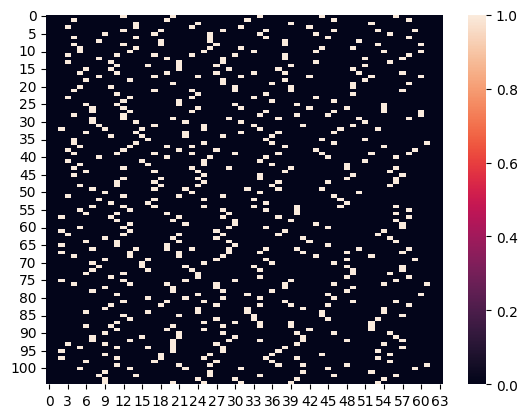

In [8]:
sns.heatmap(c_peak_loc)
plt.show()

https://www.kaggle.com/code/ankumagawa/clustering-cosine-similarity-matrix/notebook

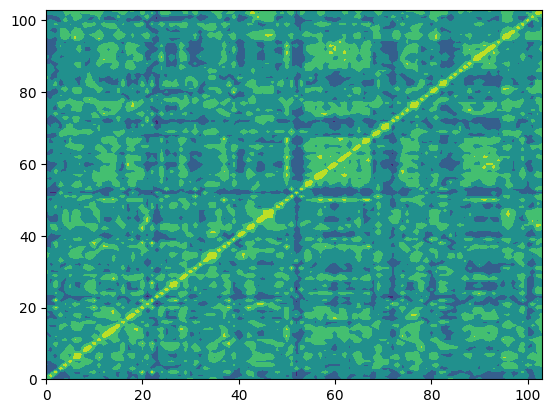

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
#c_cos_mat = cosine_similarity(c_peak_loc)
# c_cos_mat = cosine_similarity(curvs)
#sns.heatmap(c_cos_mat)
plt.contourf(c_cos_mat, levels=5)
plt.show()

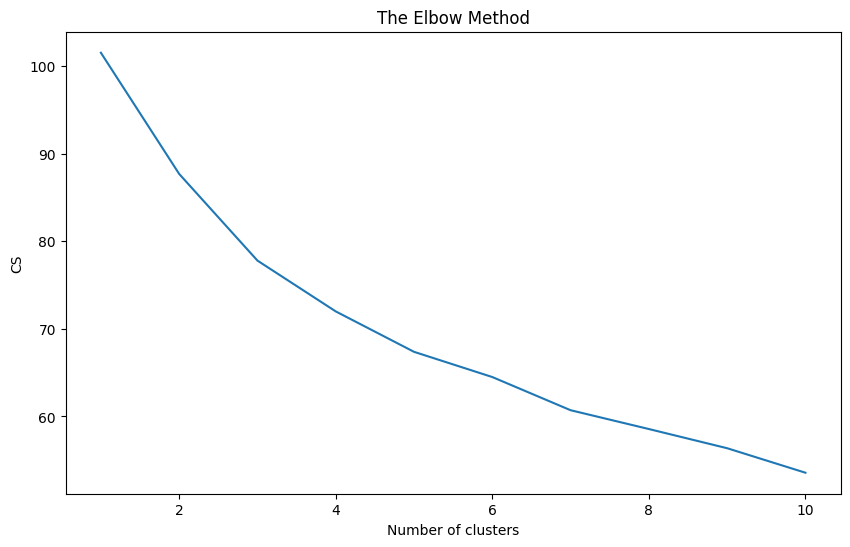

In [15]:
from sklearn.cluster import KMeans
cs = []
plt.figure(figsize=(10,6))
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(curvs)
    cs.append(kmeans.inertia_)
plt.plot(range(1, 11), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

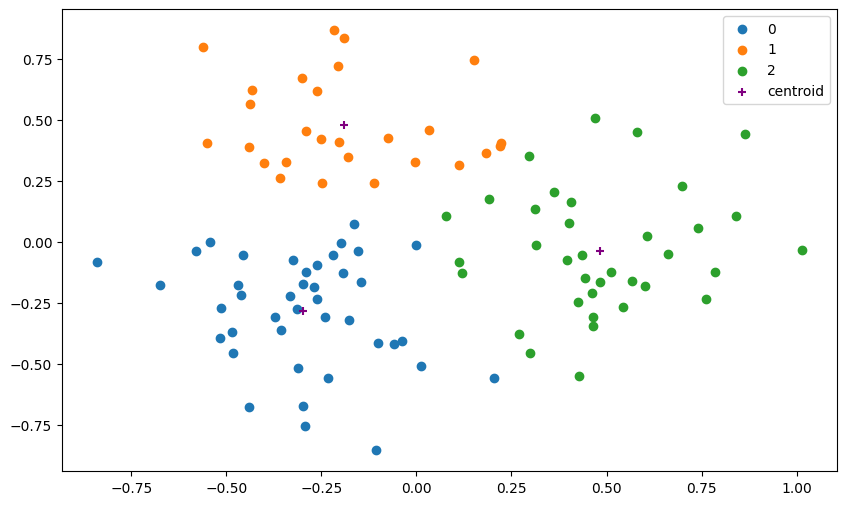

In [14]:
data = curvs

#data = c_cos_mat

pca = PCA(2)
#Transform the data
transform = pca.fit_transform(data)
 
#Import KMeans module
from sklearn.cluster import KMeans

#Initialize the class object
kmeans = KMeans(n_clusters= 3)
 
#predict the labels of clusters.
label = kmeans.fit_predict(transform)
 
#Getting unique labels
u_labels = np.unique(label)

# display (label)
# display (u_labels)

#plotting the results:
plt.figure(figsize=(10,6))
for i in u_labels:
    plt.scatter(transform[label == i , 0] , transform[label == i , 1] , label = i)
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],color='purple',marker='+',label='centroid')
plt.legend()
plt.savefig('cluster.png')
plt.show()

(2, 64)


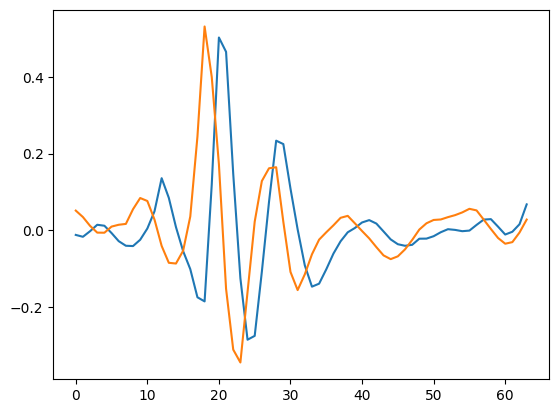

In [20]:
print (pca.components_.shape)

plt.plot (pca.components_[0,:])
plt.plot (pca.components_[1,:])